### (1)命名实体识别任务介绍
#### a:什么是命名实体识别任务
- 命名实体识别（Named Entity Recognition,简称NER）是指识别文本中具有特定意义的实体，主要包括人名、地名、机构名、专有名词等。通常包括两部分：（1）实体边界识别；（2）确定实体类别（人名、地名、机构名或其他）
- 例：“小明在北京上班”

实体类别|实体
--|:--:|
地点|北京
人物|小明

#### b:数据标注体系
- IOB1、IOB2、IOE1、IOE2、IOBES、BILOU
-IOB2标注
    - I表示实体内部，O表示实体外部，B表示实体开始
    - B/I-XXX,XXX表示具体的类别
- IOBES标注
    - I表示实体内部，O表示实体外部，B表示实体开始，E表示实体结束，S表示一个词单独形成一个命名实体
    - 有时也会使用M代替I，但本质是同一个含义

标记|说明
--|:--|
B-Person|人名开始
I-Person|人名中间
B-Organization|组织名开始
I-Organization|组织名中间
O|非命名实体

#### c:评估指标
- Precision、Recall、F1


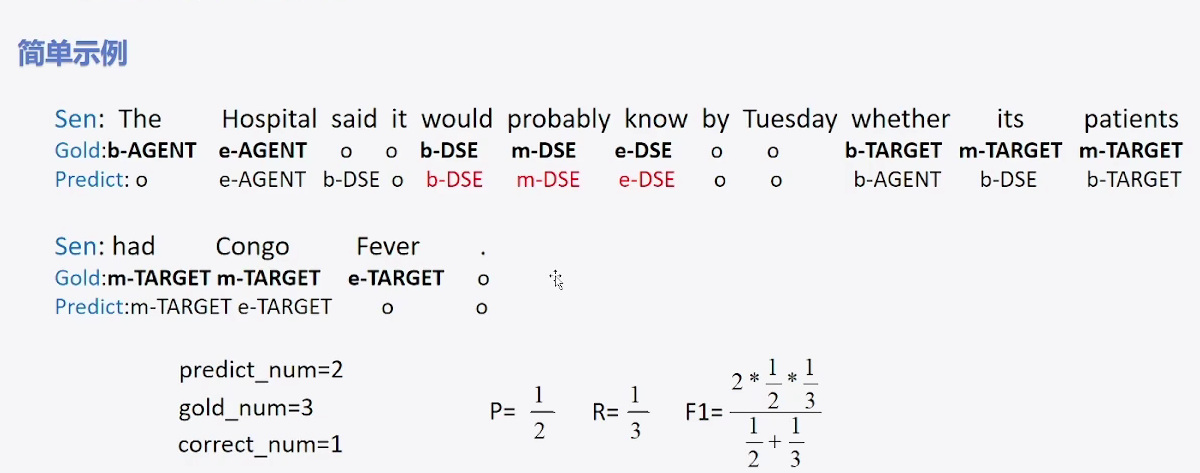


### (2)基于Transformers的解决方案
- 模型结构
    - *ModelForTokenClassification
    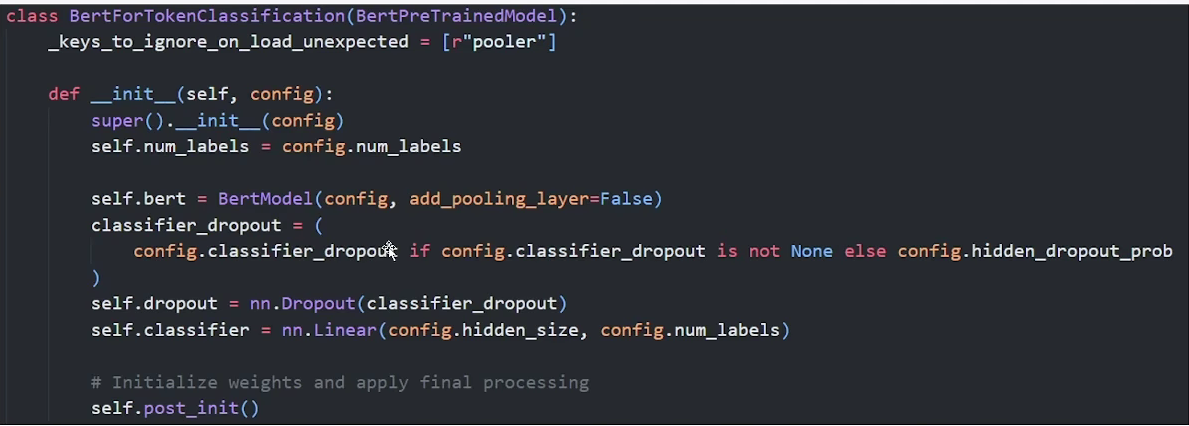
    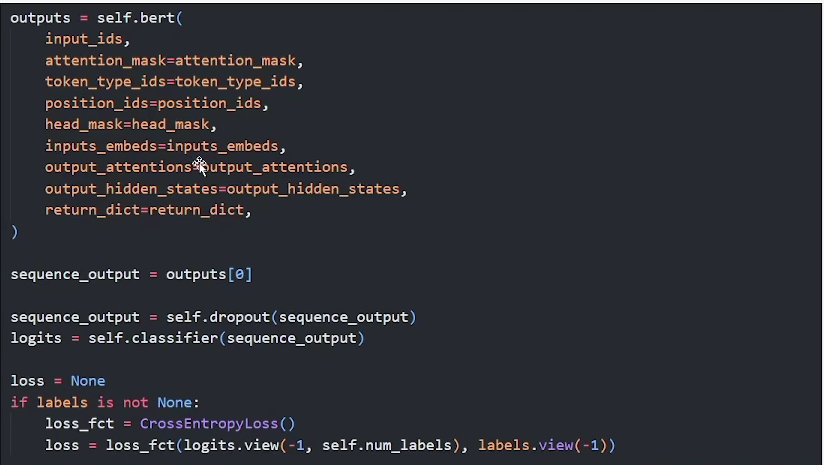
- 评估函数
    - seqeval
    - 需要额外安装seqeval
        - pip install seqeval
        - 安装过程中报错：Microsoft Visual C++14.0 or greater is required.Get it with "Microsoft C++Build Tools
        - 进入https://my.visualstudio.com,下载C++ build tools,安装
    - evaluate.load("seqeval")

### (3)代码实战演练
- 数据集
    - peoples_daily_ner
- 预训练模型
    - hfl/chinese-macbert-base

#### Step1 导入相关包

In [1]:
import evaluate
from datasets import load_dataset
from transformers import AutoTokenizer,AutoModelForTokenClassification,TrainingArguments,Trainer,DataCollatorForTokenClassification

c:\Users\ningmeng\.conda\envs\pytorch\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


#### Step2 加载数据集

In [2]:
from datasets import DatasetDict
# # 联网下载
ner_datasets=load_dataset('peoples_daily_ner',cache_dir='./data')
ner_datasets

# 读取下载好的
# ner_datasets=DatasetDict.load_from_disk('./data')
# ner_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags'],
        num_rows: 4637
    })
})

In [3]:
ner_datasets['train'][0]

{'id': '0',
 'tokens': ['海',
  '钓',
  '比',
  '赛',
  '地',
  '点',
  '在',
  '厦',
  '门',
  '与',
  '金',
  '门',
  '之',
  '间',
  '的',
  '海',
  '域',
  '。'],
 'ner_tags': [0, 0, 0, 0, 0, 0, 0, 5, 6, 0, 5, 6, 0, 0, 0, 0, 0, 0]}

In [4]:
ner_datasets['train'].features

{'id': Value(dtype='string', id=None),
 'tokens': Sequence(feature=Value(dtype='string', id=None), length=-1, id=None),
 'ner_tags': Sequence(feature=ClassLabel(names=['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC'], id=None), length=-1, id=None)}

In [5]:
# 取标签
label_list=ner_datasets['train'].features['ner_tags'].feature.names
label_list

['O', 'B-PER', 'I-PER', 'B-ORG', 'I-ORG', 'B-LOC', 'I-LOC']

#### Step3 数据集预处理

In [6]:
tokenizer=AutoTokenizer.from_pretrained('hfl/chinese-macbert-base',output_dir='./hf1')

In [7]:
tokenizer(ner_datasets['train'][0]['tokens'])

{'input_ids': [[101, 3862, 102], [101, 7157, 102], [101, 3683, 102], [101, 6612, 102], [101, 1765, 102], [101, 4157, 102], [101, 1762, 102], [101, 1336, 102], [101, 7305, 102], [101, 680, 102], [101, 7032, 102], [101, 7305, 102], [101, 722, 102], [101, 7313, 102], [101, 4638, 102], [101, 3862, 102], [101, 1818, 102], [101, 511, 102]], 'token_type_ids': [[0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0], [0, 0, 0]], 'attention_mask': [[1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1], [1, 1, 1]]}

In [8]:
# 对于已经做好的tokenizer的数据，要指定is_split_into_words=True
tokenizer(ner_datasets['train'][0]['tokens'],is_split_into_words=True)

{'input_ids': [101, 3862, 7157, 3683, 6612, 1765, 4157, 1762, 1336, 7305, 680, 7032, 7305, 722, 7313, 4638, 3862, 1818, 511, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]}

In [9]:
res=tokenizer('interesting word')
res

{'input_ids': [101, 10673, 12865, 12921, 8181, 8681, 102], 'token_type_ids': [0, 0, 0, 0, 0, 0, 0], 'attention_mask': [1, 1, 1, 1, 1, 1, 1]}

In [10]:
res.word_ids()

[None, 0, 0, 0, 0, 1, None]

In [19]:
# 借助word_ids 实现标签映射
def process_function(examples):
    tokenizer_exmaples=tokenizer(examples['tokens'],max_length=128,truncation=True,is_split_into_words=True)
    labels=[]
    for i,label in enumerate(examples['ner_tags']):
        word_ids=tokenizer_exmaples.word_ids(batch_index=i)
        label_ids=[]
        for word_id in word_ids:
            if word_id is None:
                label_ids.append(-100)
            else:
                label_ids.append(label[word_id])
        labels.append(label_ids)
    tokenizer_exmaples['labels']=labels
    return tokenizer_exmaples

In [20]:
tokenized_datasets=ner_datasets.map(process_function,batched=True)
tokenized_datasets

DatasetDict({
    train: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 20865
    })
    validation: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 2319
    })
    test: Dataset({
        features: ['id', 'tokens', 'ner_tags', 'input_ids', 'token_type_ids', 'attention_mask', 'labels'],
        num_rows: 4637
    })
})

In [ ]:
tokenized_datasets['train'][0]

#### Step4 创建模型

In [ ]:
model=AutoModelForTokenClassification.from_pretrained('hfl/chinese-macbert-base',num_labels=len(label_list))

In [ ]:
model.config

#### Step5 创建评估函数

In [21]:
seqeval=evaluate.load('seqeval')
seqeval

EvaluationModule(name: "seqeval", module_type: "metric", features: {'predictions': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence'), 'references': Sequence(feature=Value(dtype='string', id='label'), length=-1, id='sequence')}, usage: """
Produces labelling scores along with its sufficient statistics
from a source against one or more references.

Args:
    predictions: List of List of predicted labels (Estimated targets as returned by a tagger)
    references: List of List of reference labels (Ground truth (correct) target values)
    suffix: True if the IOB prefix is after type, False otherwise. default: False
    scheme: Specify target tagging scheme. Should be one of ["IOB1", "IOB2", "IOE1", "IOE2", "IOBES", "BILOU"].
        default: None
    mode: Whether to count correct entity labels with incorrect I/B tags as true positives or not.
        If you want to only count exact matches, pass mode="strict". default: None.
    sample_weight: Array-like of sha

In [ ]:
import numpy as np 
def eval_metric(pred):
    predictions,labels=pred
    predictions=np.argmax(predictions,axis=1)
    # 将id转换为原始的字符串类型的标签
    true_predictions=[
        [label_list[p] for p,l in zip(prediction,label) if l !=-100]
        for prediction,label in zip(predictions,labels)
    ]

    true_labels=[
        [label_list[l] for p,l in zip(prediction,label) if l !=-100]
        for prediction,label in zip(predictions,labels)
    ]

    result=seqeval.compute(predictions=true_predictions,references=true_labels,mode='strict',scheme='I0B2')
    return {
        'f1':result['overall_f1']
    }
        

#### Step6 配置训练参数

In [ ]:
args = TrainingArguments(
    output_dir="models_for_ner",
    per_device_train_batch_size=64,
    per_device_eval_batch_size=128,
    evaluation_strategy="epoch",
    save_strategy="epoch",
    metric_for_best_model="f1",
    load_best_model_at_end=True,
    logging_steps=50,
    num_train_epochs=1
)

#### Step7 创建训练器

In [ ]:
trainer = Trainer(
    model=model,
    args=args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["validation"],
    compute_metrics=eval_metric,
    data_collator=DataCollatorForTokenClassification(tokenizer=tokenizer)
)

#### Step8 模型训练

In [ ]:
trainer.train()

In [ ]:
trainer.evaluats(eval_dataset=tokenized_datasets['test'])

#### Step9 模型预测

In [ ]:
from transformers import pipeline

In [ ]:
# 如果模型是基于GPU训练的，那么推理时要指定device
# 对于NER任务，可以指定aggregation_strategy为simple，得到具体的实体的结果，而不是token的结果
ner_pipe=pipeline('token-classification',model=model,tokenizer=tokenizer,aggregation_strategy='simple')

In [ ]:
# 使用pipeline进行推理，要指定id2label
model.config.id2label = {idx: label for idx, label in enumerate(label_list)}
model.config

In [ ]:
ner_pipe('小明在北京上班')

In [ ]:
# 根据start和end取实际的结果
ner_result = {}
x = "小明在北京上班"
for r in res:
    if r["entity_group"] not in ner_result:
        ner_result[r["entity_group"]] = []
    ner_result[r["entity_group"]].append(x[r["start"]: r["end"]])

ner_result